In [3]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

In [4]:
class Model:
    def __init__(self,name="GBDT",alpha=0,penalty=0,topk=-1,attrN=-1,preds=None):
        self.name=name
        self.pen=penalty
        self.topk=topk
        self.preds=preds
        self.attrN=attrN
        self.alpha=alpha
        
    def get_AUC(self):
        return roc_auc_score(trueY,self.preds) if self.preds is not None else None
    
    #add some other metrics later

In [5]:
top_default=20

In [6]:
###### result files paths

result_path='result_test_us_mod_sub/'
aux_path='aux_result_test_us_mod_sub/'
attr_total=174

# result_path='result_gold_test_in_qa_split/'
# aux_path='aux_result_gold_test_in_qa_split/'
# attr_total=96


# result_path='synthetic/result_syn1_test/'
# aux_path='synthetic/aux_result_syn1_test/'
# attr_total=100



In [7]:
## preprocess

filenames_result=listdir(result_path)
filenames_aux=listdir(aux_path)
trueY=pd.read_csv(result_path+"trueY.txt",header=None)[0]
try:
    number_unused=len(pd.read_csv(result_path+"preprocess_unused.txt",header=None))
except:
    number_unused=0
attr_init_number=attr_total-number_unused

In [8]:
import collections

In [9]:
#store results when go through all files in result folder
mus=collections.defaultdict(dict) # store preds,attrN for different mu without selecting the top ranked feature
mus_t={}  # store preds for different mu with selecting the top ranked feature
BT_preds=None
BTt_default_preds=None
for filename in filenames_result:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt":
        if "_preds" in fname:
            preds=pd.read_csv(result_path+filename,header=None)[0]
            if "_mu" not in fname:
                if "BTt" in fname:
                    BTt_default_preds=preds
                else:
                    BT_preds=preds
            else:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:-6])
                if "GBFSt" in fname:
                    mus_t[mu]=preds
                else:
                    mus[mu]["preds"]=preds
        elif "feature_scores_GBFS_" in fname:
            tmp=pd.read_csv(result_path+filename,header=None)[0][0] # the first line of feature_score reports attrN
            attrN=int(tmp.split()[-1])
            idx=fname.index("_mu")
            mu=float(fname[idx+3:])
            mus[mu]["attrN"]=attrN

In [10]:
#store results when go through all files in aux_result folder
BTt_preds={}
GBDTt_preds={}
for filename in filenames_aux:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt" and "_preds" in fname:
        preds=pd.read_csv(aux_path+filename,header=None)[0]
        if "BTt" in fname:
            topk=int(fname[3:-6])
            BTt_preds[topk]=preds
        else:
            topk=int(fname[5:-6])
            GBDTt_preds[topk]=preds

In [11]:
# put result together
model_results=[]
# GBFS model
for mu in mus:
    model_results.append(Model(penalty=mu,attrN=mus[mu]["attrN"],preds=mus[mu]["preds"]))
# GBFSt model
for mu in mus_t:
    model_results.append(Model(penalty=mu,topk=top_default,attrN=top_default,preds=mus_t[mu]))
# BT model
model_results.append(Model(name="BT",preds=BT_preds,attrN=attr_init_number))

# BTt model
model_results.append(Model(name="BT",topk=top_default,attrN=top_default,preds=BTt_default_preds))
for k in BTt_preds:
    model_results.append(Model(name="BT",topk=k,attrN=k,preds=BTt_preds[k]))

# GBDTt model
for k in GBDTt_preds:
    model_results.append(Model(topk=k,attrN=k,preds=GBDTt_preds[k]))  
    
 

In [12]:
## plots
import matplotlib.pyplot as plt

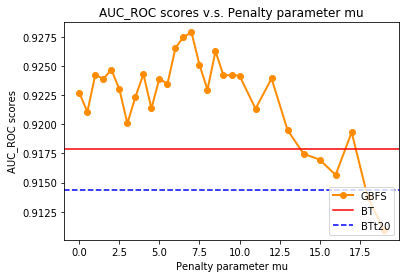

In [13]:
# plot1 AUC v.s. mus for GBFS and GBFSt
plt.figure()
lw = 2
x_axis=sorted(list([ mu for mu in mus.keys() if mu<20]))
y1_axis=[roc_auc_score(trueY,mus[x]["preds"]) for x in x_axis]
#y2_axis=[roc_auc_score(trueY,mus_t[x]) for x in x_axis]
plt.plot(x_axis, y1_axis, color='darkorange',
         lw=lw, label='GBFS',marker="o")
#plt.plot(x_axis, y2_axis, color='g',
#         lw=lw, label=f'GBFSt{top_default}',marker="o")
plt.axhline(y=roc_auc_score(trueY,BT_preds), color='r', linestyle='-',label='BT')
plt.axhline(y=roc_auc_score(trueY,BTt_default_preds), color='b', linestyle='--',label=f'BTt{top_default}')
#plt.xlim([0.0, max(x_axis)])
#plt.ylim([0.93, 0.95])
plt.xlabel('Penalty parameter mu')
plt.ylabel('AUC_ROC scores')
plt.title(f'AUC_ROC scores v.s. Penalty parameter mu')
plt.legend(loc="lower right")
plt.show()






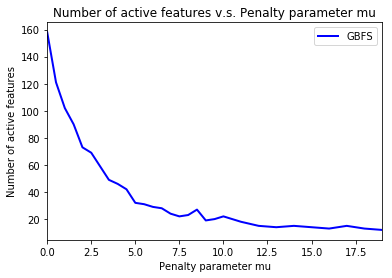

In [14]:
# plot2 attrN v.s. mus for GBFS
plt.figure()
lw = 2
x_axis=sorted(list([ mu for mu in mus.keys() if mu<20]))
y3_axis=[mus[x]["attrN"] for x in x_axis]
plt.plot(x_axis, y3_axis, color='b',
         lw=lw, label='GBFS')
plt.xlim([0.0, max(x_axis)])
#plt.ylim([20, 100])
plt.xlabel('Penalty parameter mu')
plt.ylabel('Number of active features')
plt.title('Number of active features v.s. Penalty parameter mu')
plt.legend(loc="upper right")
plt.show()


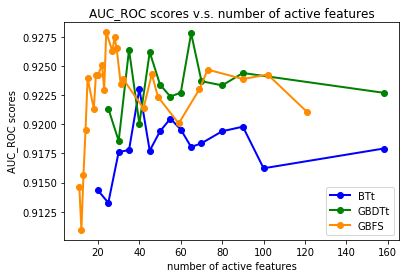

In [15]:
# plot3 AUC_ROC v.s. attrN (for best score with the given attrN for GBFSt)

BTt=collections.defaultdict(int)
GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
for model in model_results:
    if model.name=="BT":
        BTt[model.attrN]=max(BTt[model.attrN],model.get_AUC())
    elif model.name=="GBDT" and model.pen==0:
        GBDTt[model.attrN]=max(GBDTt[model.attrN],model.get_AUC())
    elif model.name=="GBDT" and 0<model.pen<=20 and model.topk==-1: 
        GBFS[model.attrN]=max(GBFS[model.attrN],model.get_AUC())
        
plt.figure()
lw = 2
x1_axis=sorted(list(BTt.keys()))
y1_axis=[BTt[x] for x in x1_axis]
x2_axis=sorted(list(GBDTt.keys()))
y2_axis=[GBDTt[x] for x in x2_axis]
x3_axis=sorted(list(GBFS.keys()))
y3_axis=[GBFS[x] for x in x3_axis]

plt.plot(x1_axis, y1_axis, color='b',
         lw=lw, label='BTt',marker="o")
plt.plot(x2_axis, y2_axis, color='g',
         lw=lw, label='GBDTt',marker="o")
plt.plot(x3_axis, y3_axis, color='darkorange',
         lw=lw, label='GBFS',marker="o")
#plt.ylim([0.93, 0.95])
plt.xlabel('number of active features')
plt.ylabel('AUC_ROC scores')
plt.title(f'AUC_ROC scores v.s. number of active features')
plt.legend(loc="lower right")
plt.show()




In [16]:
########### with different alphas

result_path='synthetic/result_syn2_test/'
aux_path='synthetic/aux_result_syn2_test/'
attr_total=50
top_default=15



In [17]:
## preprocess

filenames_result=listdir(result_path)
filenames_aux=listdir(aux_path)
trueY=pd.read_csv(result_path+"trueY.txt",header=None)[0]
try:
    number_unused=len(pd.read_csv(result_path+"preprocess_unused.txt",header=None))
except:
    number_unused=0
attr_init_number=attr_total-number_unused

alphas=pd.read_csv("synthetic/alphas.txt",header=None)[0]

In [18]:
import collections

In [19]:
# store results when go through all files in result folder
# index result like [(mu,alpha)]
mus=collections.defaultdict(dict) # store preds,attrN for different mu and alpha without selecting the top ranked feature
mus_t={}  # store preds for different mu and alpha with selecting the top ranked feature
BT_preds={} # for different alpha
BTt_default_preds={} # for different alpha
for filename in filenames_result:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt" and "_alpha" in fname:
        alpha=float(fname[fname.index("_alpha")+6:])
        if "_preds" in fname:
            preds=pd.read_csv(result_path+filename,header=None)[0]
            if "_mu" not in fname:
                if "BTt" in fname:
                    BTt_default_preds[alpha]=preds
                else:
                    BT_preds[alpha]=preds
            else:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:fname.index("_preds")])
                if "GBFSt" in fname:
                    mus_t[mu,alpha]=preds
                else:
                    mus[mu,alpha]["preds"]=preds
        elif "feature_scores_GBFS_" in fname:
            tmp=pd.read_csv(result_path+filename,header=None)[0][0] # the first line of feature_score reports attrN
            attrN=int(tmp.split()[-1])
            idx=fname.index("_mu")
            mu=float(fname[idx+3:fname.index("_alpha")])
            mus[mu,alpha]["attrN"]=attrN

In [20]:
#store results when go through all files in aux_result folder
BTt_preds={}
GBDTt_preds={}
for filename in filenames_aux:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt" and "_preds" in fname:
        alpha=float(fname[fname.index("_alpha")+6:])
        preds=pd.read_csv(aux_path+filename,header=None)[0]
        if "BTt" in fname:
            topk=int(fname[3:fname.index("_preds")])
            BTt_preds[topk,alpha]=preds
        else:
            topk=int(fname[5:fname.index("_preds")])
            GBDTt_preds[topk,alpha]=preds

In [21]:
# put result together
model_results=collections.defaultdict(list) # indexed by alpha
# GBFS model
for mu,alpha in mus:
    model_results[alpha].append(Model(penalty=mu,alpha=alpha,attrN=mus[mu,alpha]["attrN"],preds=mus[mu,alpha]["preds"]))
# GBFSt model
for mu,alpha in mus_t:
    model_results[alpha].append(Model(penalty=mu,alpha=alpha,topk=top_default,attrN=top_default,preds=mus_t[mu,alpha]))
# BT model
for alpha in BT_preds:
    model_results[alpha].append(Model(name="BT",alpha=alpha,preds=BT_preds[alpha],attrN=attr_init_number))
    
# BTt model
for alpha in BTt_default_preds:
    model_results[alpha].append(Model(name="BT",alpha=alpha,topk=top_default,attrN=top_default,preds=BTt_default_preds[alpha]))
for k,alpha in BTt_preds:
    model_results[alpha].append(Model(name="BT",alpha=alpha,topk=k,attrN=k,preds=BTt_preds[k,alpha]))

# GBDTt model
for k,alpha in GBDTt_preds:
    model_results[alpha].append(Model(topk=k,alpha=alpha,attrN=k,preds=GBDTt_preds[k,alpha]))  
    

In [22]:
## plots
import matplotlib.pyplot as plt

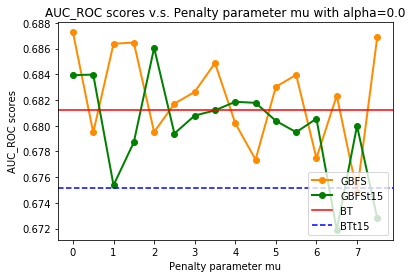

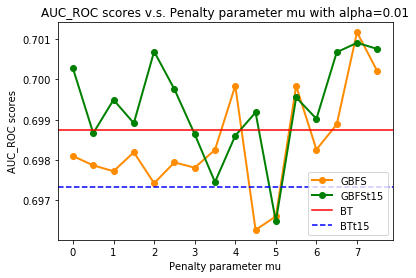

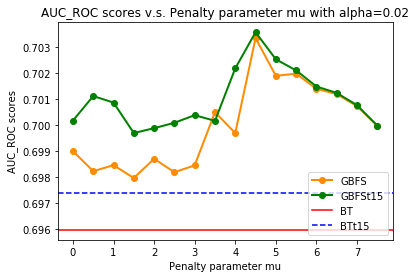

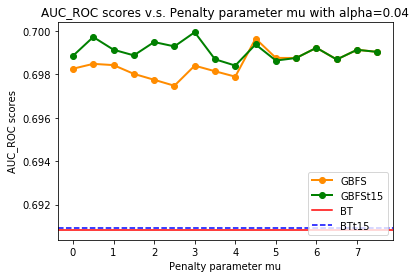

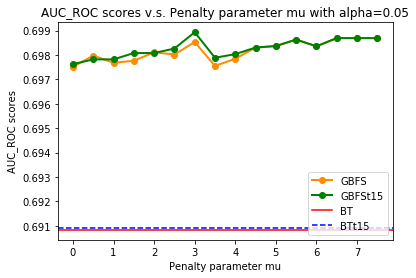

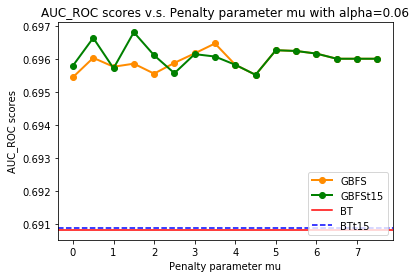

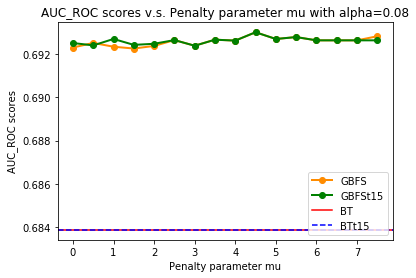

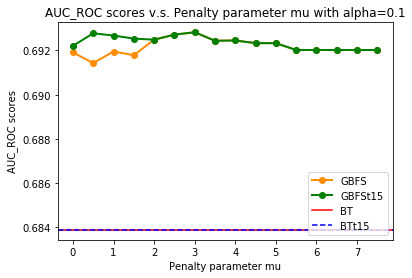

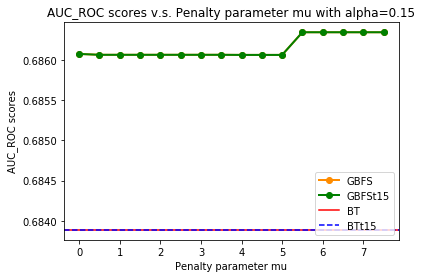

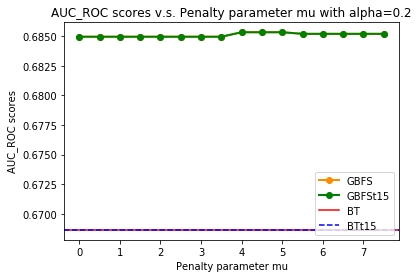

In [23]:
# plot1 AUC v.s. mus for GBFS and GBFSt

for alpha in alphas:
    plt.figure()
    lw = 2
    x_axis=sorted([idx[0] for idx in mus.keys() if idx[1]==alpha])
    y1_axis=[roc_auc_score(trueY,mus[x,alpha]["preds"]) for x in x_axis]
    y2_axis=[roc_auc_score(trueY,mus_t[x,alpha]) for x in x_axis]
    plt.plot(x_axis, y1_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    plt.plot(x_axis, y2_axis, color='g',
             lw=lw, label=f'GBFSt{top_default}',marker="o")
    plt.axhline(y=roc_auc_score(trueY,BT_preds[alpha]), color='r', linestyle='-',label='BT')
    plt.axhline(y=roc_auc_score(trueY,BTt_default_preds[alpha]), color='b', linestyle='--',label=f'BTt{top_default}')
    #plt.xlim([0.0, max(x_axis)])
    #plt.ylim([0.93, 0.95])
    plt.xlabel('Penalty parameter mu')
    plt.ylabel('AUC_ROC scores')
    plt.title(f'AUC_ROC scores v.s. Penalty parameter mu with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()

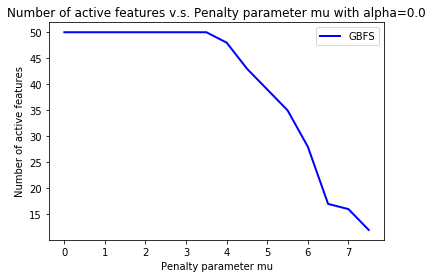

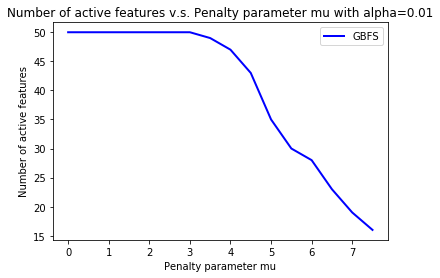

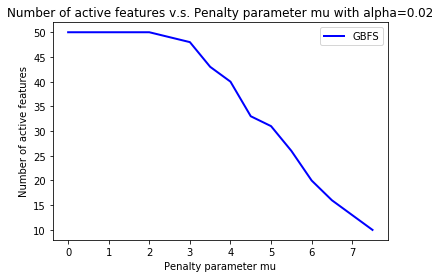

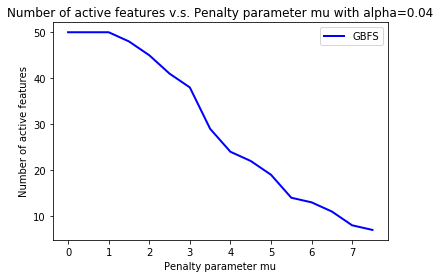

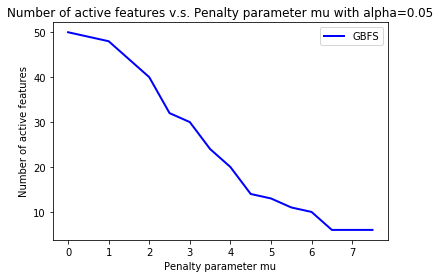

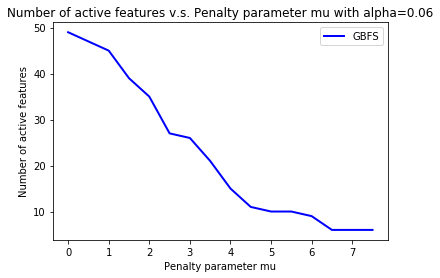

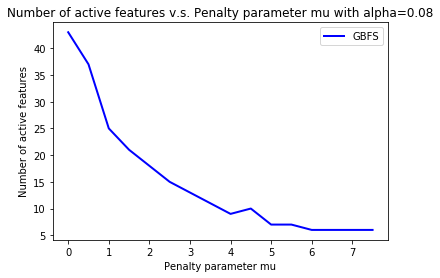

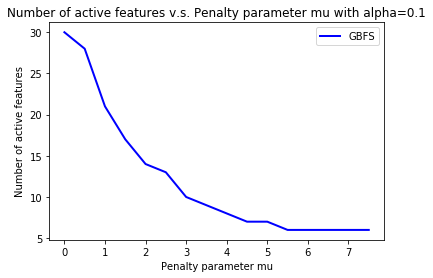

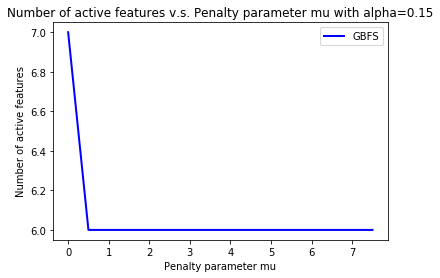

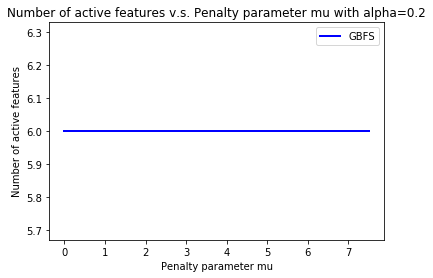

In [24]:
# plot2 attrN v.s. mus for GBFS
for alpha in alphas:
    plt.figure()
    lw = 2
    x_axis=sorted([idx[0] for idx in mus.keys() if idx[1]==alpha])
    y3_axis=[mus[x,alpha]["attrN"] for x in x_axis]
    plt.plot(x_axis, y3_axis, color='b',
             lw=lw, label='GBFS')
    #plt.xlim([0.0, max(x_axis)])
    #plt.ylim([20, 100])
    plt.xlabel('Penalty parameter mu')
    plt.ylabel('Number of active features')
    plt.title(f'Number of active features v.s. Penalty parameter mu with alpha={alpha}')
    plt.legend(loc="upper right")
    plt.show()

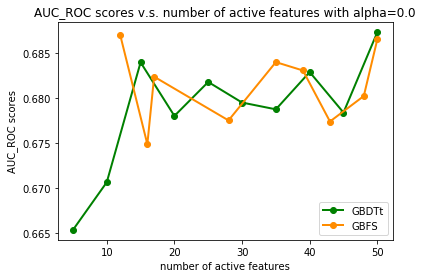

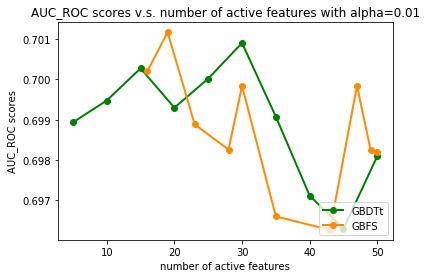

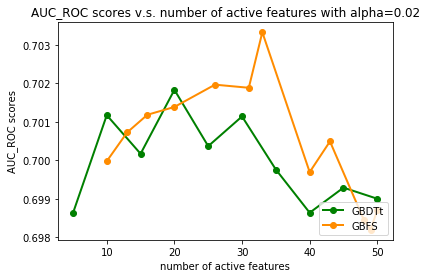

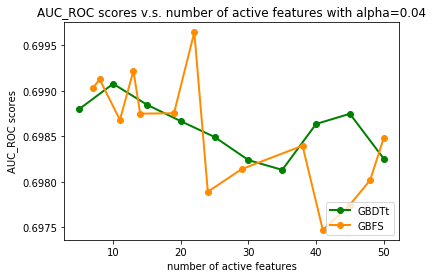

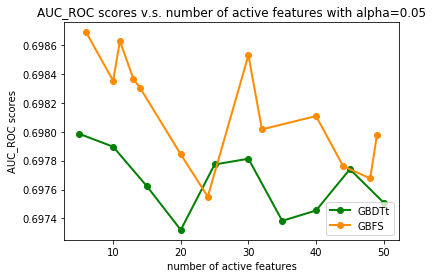

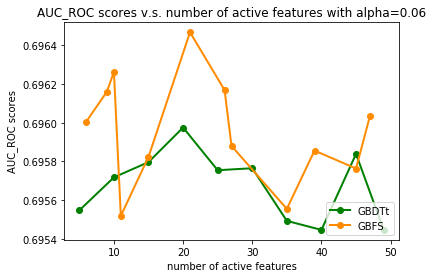

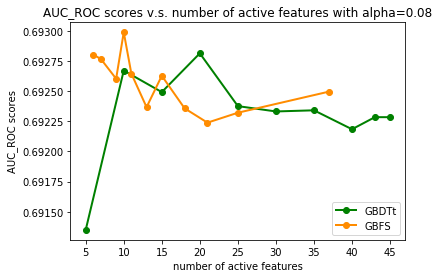

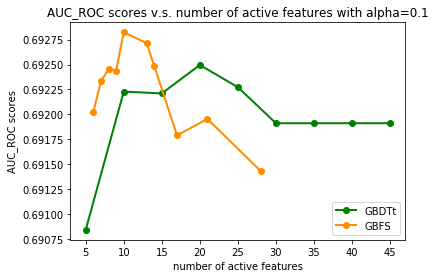

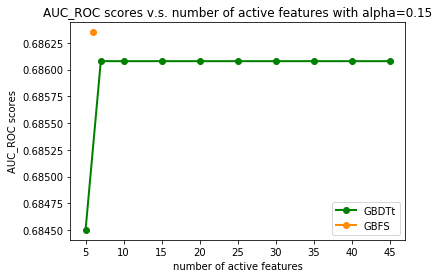

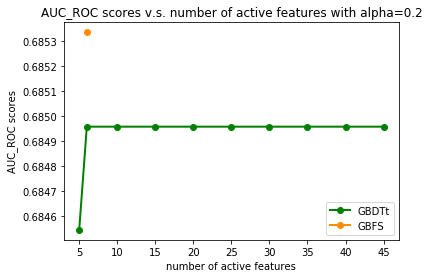

In [25]:
# plot3 AUC_ROC v.s. attrN (for best score with the given attrN for GBFSt) given alpha

BTt=collections.defaultdict(int)
GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
for alpha in model_results:
    for model in model_results[alpha]:
        if model.name=="BT":
            BTt[model.attrN,alpha]=max(BTt[model.attrN,alpha],model.get_AUC())
        elif model.name=="GBDT" and model.pen==0:
            GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_AUC())
        elif model.name=="GBDT" and model.pen>0 and model.topk==-1: 
            GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_AUC())
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in BTt.keys() if idx[1]==alpha])
    y1_axis=[BTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y2_axis=[GBDTt[x,alpha] for x in x2_axis]
    x3_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y3_axis=[GBFS[x,alpha] for x in x3_axis]

    #plt.plot(x1_axis, y1_axis, color='b',
    #         lw=lw, label='BTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x3_axis, y3_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    #plt.ylim([0.93, 0.95])
    plt.xlabel('number of active features')
    plt.ylabel('AUC_ROC scores')
    plt.title(f'AUC_ROC scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()